# Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy import special
from scipy.optimize import curve_fit
from tqdm import tqdm
import scipy as sy
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.optimize import bisect
import healpy as H
import pickle



# Import MC data and PPPC4 flux

In [2]:
input_file = "neutrino_mc.csv"
input_data = pd.read_csv(input_file)

# Define masks to identify different neutrino flavors
nue_mask = (np.abs(input_data["pdg"]) == 12)
numu_mask = (np.abs(input_data["pdg"]) == 14)
nutau_mask = (np.abs(input_data["pdg"]) == 16)

# Load data (deserialize)
with open('ann_flux.pickle', 'rb') as handle:
    ann_data = pickle.load(handle)

DM_masses = np.array([10, 30, 100, 300, 1000])
channels = np.array(['b_', 'W_','numu_','tau_'])

## Setting up global variables

In [56]:
# Size of maps:
nside= 16
npix = H.nside2npix(nside)

# For ud_grading maps:
nside_course = 8
ud_grade_factor = 2**(nside/nside_course)

energy_bins_course = np.logspace(0., 3., num=16)
binwidth = 0.2
bin_index = np.arange(16)

# Number of samples:
nsamples = 1000 #1000 atmospheric
nsamples2 = 1000 #1000 galactic
samples_ts = 10000 #10000
samples_ts_sig = 1000 #1000
#eta_sim_sig = np.linspace(1e-2,40,11)
eta_sim_sig = 10**(np.linspace(-6, 1, 21))

# Live time:
T_live = 10*365*24*60**2 

## Definition of TS

In [4]:
def TS(eta, N_ij, mu_s_ij, mu_b_ij):
        
    nonzero_bg = np.where(mu_b_ij != 0)
    fraction = np.zeros_like(mu_b_ij)
    fraction[nonzero_bg] = mu_s_ij[nonzero_bg] / mu_b_ij[nonzero_bg]
     
    ts = np.sum(-2*N_ij[None,:,:]*np.log(1 + eta[:, None, None]*fraction) + 2*eta[:, None, None]*mu_s_ij[None,:,:],
               axis=(1, 2)) 
    return ts

# Calculate atmospheric flux 

In [5]:
def mu_tau_osc_prob(true_energy, true_zenith) :
    
    # Get baseline [km] (propagation distance) from zenith angle
    # Unit is km
    true_coszen = np.cos(true_zenith)
    earth_radius = 6371.
    production_height = 15. # Assuming neutrino produced 15 km above surface
    detector_depth = 1. # Assuming detector depth of 1 km
    baseline = -earth_radius*true_coszen +  np.sqrt( (earth_radius*true_coszen)**2 - earth_radius**2 + (earth_radius+production_height+detector_depth)**2 )

    # Compute oscillation transition probability
    theta = np.deg2rad(45.) # Maximal mixing
    deltam2 = 2.5e-3
    Pmutau = ( np.sin(2.*theta)**2 ) * np.sin( ( 1.27 * deltam2 * baseline ) / true_energy )**2.
    
    return Pmutau

In [6]:
import nuflux

nuflux_dict = {12: nuflux.NuE, -12: nuflux.NuEBar, 14: nuflux.NuMu, -14: nuflux.NuMuBar,
              16: nuflux.NuMu, -16: nuflux.NuMuBar}
flux = nuflux.makeFlux('IPhonda2014_spl_solmin')

intp_flux = np.zeros(len(np.array(input_data['pdg'])))
for nu_pdg in [12, -12, 14, -14, 16, -16]:
    nu_idx = np.where(input_data['pdg'] == nu_pdg)[0]
    intp_flux[nu_idx] += flux.getFlux(nuflux_dict[nu_pdg], np.array(input_data['true_energy'])[nu_idx], np.cos(input_data['true_zenith'][nu_idx]))*1e4 #conversion from cm^-2 to m^-2
#units of flux is GeV^-1 m^-2 s^-1 sr^-1

In [7]:
def honda_flux_cut(nside, lowlimit, highlimit, add_phase=True, Type='12'):

    
    if add_phase == True:
        added_fase = np.random.uniform(0, 1, len(intp_flux))*2*np.pi
    else:
        added_fase = np.zeros_like(intp_flux)
        
    azimuth_reco = np.array(input_data['reco_azimuth'])+added_fase
    
    ## OSCILLATION 
    Pmutau = mu_tau_osc_prob(input_data["true_energy"], input_data["true_zenith"])

    # Now compute weights representing event rates
    # This is flux * osc * weight
    rate_weight = np.zeros_like(input_data["weight"]) #weights from the csv file have the units m^2 
    rate_weight[nue_mask] = intp_flux[nue_mask] * input_data["weight"][nue_mask] # No oscillations in 2 flavor model
    rate_weight[numu_mask] = intp_flux[numu_mask] * (1. - Pmutau[numu_mask]) * input_data["weight"][numu_mask] # numu flux, less those that oscillation
    rate_weight[nutau_mask] = intp_flux[nutau_mask] * Pmutau[nutau_mask] * input_data["weight"][nutau_mask] # nutau purely come from oscillations in the numu flux
    
        
    if Type == '12':
        indicies = nue_mask
        type_energies = np.array(input_data['reco_energy'])[indicies]
        energy_indicies = np.where(((type_energies) >= lowlimit) & ((type_energies) < highlimit))[0]
        cut_rate_weight = rate_weight[indicies][energy_indicies]
    if Type == '14':
        indicies = numu_mask
        type_energies = np.array(input_data['reco_energy'])[indicies]
        energy_indicies = np.where(((type_energies) >= lowlimit) & ((type_energies) < highlimit))[0]
        cut_rate_weight = rate_weight[indicies][energy_indicies]
    if Type == '16':
        indicies = nutau_mask
        type_energies = np.array(input_data['reco_energy'])[indicies]
        energy_indicies = np.where(((type_energies) >= lowlimit) & ((type_energies) < highlimit))[0]
        cut_rate_weight = rate_weight[indicies][energy_indicies]

    EQ_theta = np.pi - np.array(np.array(input_data['reco_zenith'])[indicies])[energy_indicies]
    EQ_phi = np.array(azimuth_reco[indicies])[energy_indicies]
    
    EQ_pixels = H.ang2pix(nside,EQ_theta,EQ_phi)
   
    npix = H.nside2npix(nside)
    background_map = np.zeros(npix)
    
    #weight = np.array(input_data['weight'][indicies])
    #intp_flux[indicies][these_pixels]*weight[these_pixels]*
    
    unique_EQ_pixels = np.unique(EQ_pixels)
    for i in range(len(unique_EQ_pixels)):
        these_pixels = np.where(EQ_pixels == unique_EQ_pixels[i])[0]
        background_map[unique_EQ_pixels[i]] += np.sum(cut_rate_weight[these_pixels])
    
    return background_map #background units Gev^-1 sr^-1 m^2 s^-1 

__100 samples, livetime of 10 yrs, 15 energy bins__

In [8]:
unitless_bg_nue = np.zeros((len(bin_index),H.nside2npix(nside)))
unitless_bg_numu = np.zeros((len(bin_index),H.nside2npix(nside)))
unitless_bg_nutau = np.zeros((len(bin_index),H.nside2npix(nside)))

for j in tqdm(range(len(bin_index))):
    left = 10**(bin_index[j]*binwidth)
    right = 10**((bin_index[j]+1)*binwidth)
    
    data_samples_bg_nue = np.zeros(H.nside2npix(nside))
    data_samples_bg_numu = np.zeros(H.nside2npix(nside))
    data_samples_bg_nutau = np.zeros(H.nside2npix(nside))
    
    for i in range(nsamples):
        background_template_nue = honda_flux_cut(nside, left, right, add_phase=True, Type='12')
        data_samples_bg_nue += background_template_nue

        background_template_numu = honda_flux_cut(nside, left, right, add_phase=True, Type='14')
        data_samples_bg_numu += background_template_numu

        background_template_nutau = honda_flux_cut(nside, left, right, add_phase=True, Type='16')
        data_samples_bg_nutau += background_template_nutau

    data_samples_bg_nue = data_samples_bg_nue/nsamples * T_live
    data_samples_bg_numu = data_samples_bg_numu/nsamples* T_live
    data_samples_bg_nutau = data_samples_bg_nutau/nsamples * T_live
    
    unitless_bg_nue[j] += data_samples_bg_nue
    unitless_bg_numu[j] += data_samples_bg_numu
    unitless_bg_nutau[j] += data_samples_bg_nutau

100%|██████████| 16/16 [00:42<00:00,  2.65s/it]


In [9]:
all_atmospheric_neutrinos = unitless_bg_nue + unitless_bg_numu + unitless_bg_nutau
np.save('all_atmospheric_neutrinos.npy',all_atmospheric_neutrinos)
expect_bg = H.ud_grade(all_atmospheric_neutrinos,nside_course)*ud_grade_factor

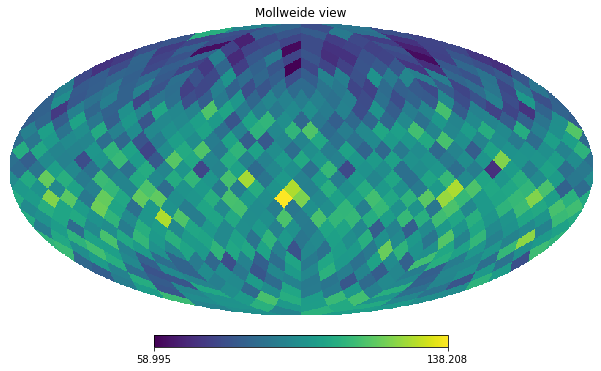

In [10]:
H.mollview(H.ud_grade(all_atmospheric_neutrinos[0],nside_course)*ud_grade_factor)

# Calculate J and D factor

In [11]:
def rho_NFW(r):
    rho0 = 0.4 #GeV pr cubic cm
    gamma = 1 #dimensionless
    r_s = 17#kpc
    return rho0 /((r/r_s)**gamma * (1 + (r/r_s))**(3-gamma))

boundaries = np.logspace(-4, 3, 1000) #from 0 til 1000 kpc

R_gc = 7.5 #location of the galactic center from earth 

def JDfactor(theta, phi, line, lonlat=True): #dimensionless
    
    if lonlat == False:
        r = np.sqrt(line**2 + R_gc**2 - 2*line*R_gc*np.sin(theta)*np.cos(phi)) #theta[0,pi] and phi[0,2pi] for False
    else:
        r = np.sqrt(line**2 + R_gc**2 - 2*line*R_gc*np.cos(theta)*np.cos(phi)) #galactic coordinates is True
        
    density_NFW = rho_NFW(r) #density from density profile

    J_NFW = integrate.trapz(density_NFW**2, line)
    D_NFW = integrate.trapz(density_NFW, line) 
    
    norm_J_NFW = J_NFW * (3.086*1e19*1e12/(8*np.pi)) #m^-5 GeV^2 
    norm_D_NFW = D_NFW  *(3.086*1e19*1e6)/(4*np.pi) #m^-2 GeV 
    
    return norm_J_NFW, norm_D_NFW

In [12]:


J_map = np.zeros(npix)
D_map = np.zeros(npix)
size = H.get_map_size(J_map)

saved_theta = np.zeros(npix)
saved_phi = np.zeros(npix)
saved_J = np.zeros(npix)
saved_D = np.zeros(npix)

for i in tqdm(range(size)):
    theta0, phi0 = H.pix2ang(nside, i, lonlat=False) ##co-latitude and longitude in radians
    saved_theta[i] += theta0
    saved_phi[i] += phi0
 
    Dtheta = JDfactor(theta0, phi0, boundaries, lonlat=False)[1]
    Jtheta = JDfactor(theta0, phi0, boundaries, lonlat=False)[0] #calculating the Jfactor in galactic coordinates
    saved_J[i] += Jtheta
    saved_D[i] += Dtheta
    
pixel_indicies = H.ang2pix(nside, np.array(saved_theta) ,np.array(saved_phi), lonlat=False) #takes long/lat in degrees
J_map[pixel_indicies] = saved_J
D_map[pixel_indicies] = saved_D
norm_J_map = J_map/np.sum(J_map)
norm_D_map = D_map/np.sum(D_map)

100%|██████████| 3072/3072 [00:00<00:00, 3575.56it/s]


In [13]:
J_NFW_template = J_map
D_NFW_template = D_map

# Calculation of the galactic flux

In [14]:
def cut_template(nside, indicies, energy_indicies, added_fase, Type='12'):
     
    if Type=='12':
        indicies = nue_mask
    if Type=='14':
        indicies = numu_mask
    if Type=='16':
        indicies = nutau_mask
          
    
    r = H.Rotator(coord=['C','G'])
    EQ_theta = np.pi - np.array(np.array(input_data['true_zenith'][indicies])[energy_indicies])
    EQ_phi = np.array(np.array(input_data['true_azimuth'][indicies])[energy_indicies]) + added_fase
    
    EQ_pixels = H.ang2pix(nside,EQ_theta,EQ_phi)

    gal_theta, gal_phi = r(EQ_theta,EQ_phi)
    GAL_pixels = H.ang2pix(nside,gal_theta, gal_phi)
    
    return GAL_pixels

In [15]:
def cut_Galactic_flavors(nside, E, channel, true_azimuth, true_zenith, lowlimit, highlimit, DM_mass=1000, J=True, Type='12', add_phase=True): #Type is 12, 14, 16
    
    #Average neutrino flavor oscillation
    AvPMNS = np.array([[0.552238, 0.170924, 0.276838],[0.170924, 0.453893, 0.375182],[0.276838, 0.375182, 0.34798]]) #calculated in Mathematica
    
    ave_nue_flux, ave_numu_flux, ave_nutau_flux = AvPMNS @ np.array([channel[0], channel[1], channel[2]]) #dN/dE [GeV^-1]
    
    #Interpolating data
    nue_GC_flux = interp1d(E,ave_nue_flux,bounds_error=False,fill_value=0)
    numu_GC_flux = interp1d(E,ave_numu_flux,bounds_error=False,fill_value=0)
    nutau_GC_flux = interp1d(E,ave_nutau_flux,bounds_error=False,fill_value=0)
    
    #Calculating flux from interpolation
    if Type == '12':
        indicies = nue_mask
        type_energies = input_data['reco_energy'][indicies]
        energy_indicies = np.where(((type_energies) >= lowlimit) & ((type_energies) < highlimit))[0]
        intp_flux = nue_GC_flux(np.array(input_data['true_energy'][indicies])[energy_indicies])
        if add_phase == True:
            added_fase = np.random.uniform(0, 1, len(intp_flux))*2*np.pi
        else:
            added_fase = np.zeros_like(intp_flux)
        GAL_pixels = cut_template(nside, indicies, energy_indicies, added_fase, Type='12')
        
    elif Type == '14':
        indicies = numu_mask
        type_energies = input_data['reco_energy'][indicies]
        energy_indicies = np.where(((type_energies) >= lowlimit) & ((type_energies) < highlimit))[0]
        intp_flux = numu_GC_flux(np.array(input_data['true_energy'][indicies])[energy_indicies])
        if add_phase == True:
            added_fase = np.random.uniform(0, 1, len(intp_flux))*2*np.pi
        else:
            added_fase = np.zeros_like(intp_flux)
        GAL_pixels = cut_template(nside, indicies, energy_indicies, added_fase, Type='14')
        
    elif Type == '16':
        indicies = nutau_mask
        type_energies = input_data['reco_energy'][indicies]
        energy_indicies = np.where(((type_energies) >= lowlimit) & ((type_energies) < highlimit))[0]
        intp_flux = nutau_GC_flux(np.array(input_data['true_energy'][indicies])[energy_indicies])
        if add_phase == True:
            added_fase = np.random.uniform(0, 1, len(intp_flux))*2*np.pi
        else:
            added_fase = np.zeros_like(intp_flux)
        GAL_pixels = cut_template(nside, indicies, energy_indicies, added_fase, Type='16')
    
    if J==True:
        benchmark = 1e-30
        DM_map = J_NFW_template *benchmark /(DM_mass**2)
    else:
        gamma = 1e-24
        DM_map = D_NFW_template * gamma/DM_mass           

    weight = np.array(np.array(input_data['weight'][indicies])[energy_indicies])
      
    r = H.Rotator(coord=['C','G'])
    EQ_theta = np.pi - np.array(np.array(true_zenith[indicies])[energy_indicies])
    
    EQ_phi = np.array(np.array(true_azimuth[indicies])[energy_indicies]) + added_fase
    
    EQ_pixels = H.ang2pix(nside,EQ_theta,EQ_phi)
        
    
    npix = H.nside2npix(nside)
    signalmap = np.zeros(npix)
    
    rate_weight = np.array(input_data['weight'][indicies])[energy_indicies] * intp_flux 
    ''' 
    for i in range(len(EQ_pixels)):
        signalmap[EQ_pixels[i]] += norm_DM_map[GAL_pixels[i]]*intp_flux[i]*weight[i] 
    '''  
    unique_EQ_pixels = np.unique(EQ_pixels)
    #unique_GAL_pixels = np.unique(GAL_pixels)
    for i in range(len(unique_EQ_pixels)):
        these_EQ_pixels = np.where(EQ_pixels == unique_EQ_pixels[i])[0]
        these_GAL_pixels = GAL_pixels[these_EQ_pixels]
        signalmap[unique_EQ_pixels[i]] += np.sum(rate_weight[these_EQ_pixels]* DM_map[these_GAL_pixels])
                  
    return signalmap

        

# Make all signal maps

In [16]:
def all_sig_maps(E, channel_flux, mass):
    all_galactic_neutrinos = []
    unitless_sig_nue = np.zeros((len(bin_index),H.nside2npix(nside)))
    unitless_sig_numu = np.zeros((len(bin_index),H.nside2npix(nside)))
    unitless_sig_nutau = np.zeros((len(bin_index),H.nside2npix(nside)))

    for j in range(len(bin_index)):

        try:
            left = 10**(bin_index[j]*binwidth)
            right = 10**((bin_index[j]+1)*binwidth)

            data_samples_sig_nue = np.zeros(H.nside2npix(nside))
            data_samples_sig_numu = np.zeros(H.nside2npix(nside))
            data_samples_sig_nutau = np.zeros(H.nside2npix(nside))

            for i in range(nsamples2):
                signal_template_nue = cut_Galactic_flavors(nside,E, channel_flux , input_data['true_azimuth'],input_data['true_zenith'],left, right, DM_mass=mass,  J=False, Type='12', add_phase=True)
                data_samples_sig_nue += signal_template_nue

                signal_template_numu = cut_Galactic_flavors(nside, E, channel_flux , input_data['true_azimuth'],input_data['true_zenith'],left, right, DM_mass=mass,  J=False, Type='14', add_phase=True)
                data_samples_sig_numu += signal_template_numu

                signal_template_nutau = cut_Galactic_flavors(nside, E, channel_flux , input_data['true_azimuth'],input_data['true_zenith'],left, right, DM_mass=mass , J=False, Type='16', add_phase=True)
                data_samples_sig_nutau += signal_template_nutau

            data_samples_sig_nue = data_samples_sig_nue/nsamples2 * T_live 
            data_samples_sig_numu = data_samples_sig_numu/nsamples2 * T_live
            data_samples_sig_nutau = data_samples_sig_nutau/nsamples2 * T_live 

            unitless_sig_nue[j] += data_samples_sig_nue
            unitless_sig_numu[j] += data_samples_sig_numu
            unitless_sig_nutau[j] += data_samples_sig_nutau

        except IndexError:
            print('Continue!')
            continue

    all_galactic_neutrinos.append(unitless_sig_nue+ unitless_sig_numu + unitless_sig_nutau)
        
    return all_galactic_neutrinos


In [17]:
all_galactic_neutrinos_per_channel = []
for c in range(len(channels)):
    all_galactic_neutrinos_per_mass = []
    for m in range(len(DM_masses)):
        all_galactic_neutrinos_per_mass.append(all_sig_maps(ann_data['E_'+channels[c]+str(DM_masses[m])], ann_data['E_nu_'+channels[c]+str(DM_masses[m])], DM_masses[m]))
        print((c+1)*(m+1))
    all_galactic_neutrinos_per_channel.append(all_galactic_neutrinos_per_mass)
   

Continue!
1
Continue!
2
Continue!
3
Continue!
4
Continue!
5
Continue!
2
Continue!
4
Continue!
6
Continue!
8
Continue!
10
Continue!
3
Continue!
6
Continue!
9
Continue!
12
Continue!
15
Continue!
4
Continue!
8
Continue!
12
Continue!
16
Continue!
20


## Defining the total signal (Background + signal)

In [18]:
all_galactic_neutrinos_per_channel = np.array(all_galactic_neutrinos_per_channel)
np.save('all_galactic_neutrinos_per_channel.npy',all_galactic_neutrinos_per_channel)
total_signal = all_galactic_neutrinos_per_channel+all_atmospheric_neutrinos

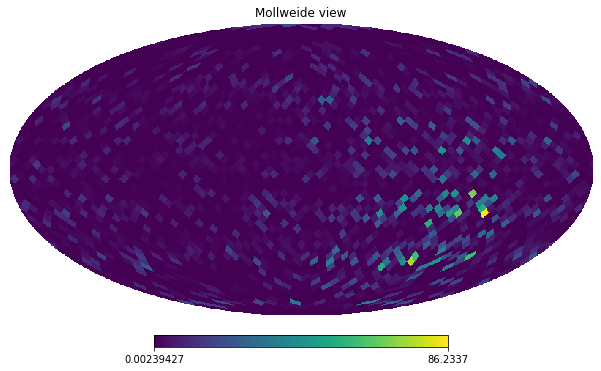

In [49]:
H.mollview(all_galactic_neutrinos_per_channel[2][3][0][10])

# Defining TS functions for background and signal

In [20]:
def TS_bg(expectation_values_sig):
    min_values_bg = np.zeros(samples_ts)
    TS_min_bg = np.zeros(samples_ts)
    eta_sim_bg = 0.0
    for i in tqdm(range(samples_ts)):
        events_bg = np.random.poisson(lam=expect_bg)
        events_sig = np.random.poisson(lam=expectation_values_sig*eta_sim_bg)
        events_bg_sig = events_bg + events_sig
        
        ts_minimize = lambda leta, N_ij=events_bg_sig, mu_s_ij=expectation_values_sig, mu_b_ij=expect_bg: TS(np.exp(leta), N_ij, mu_s_ij, mu_b_ij)
        res = minimize(ts_minimize, x0=[0.0])
        #res = minimize(ts_minimize, x0=[0.0], bounds=((1e-5, 1e2), ))
        min_values_bg[i] = res.x
        #print(res.x)
        TS_min_bg[i] = max(0.0, -ts_minimize(res.x))
        
    return TS_min_bg

In [21]:
def TS_sig(expectation_values_sig):
    min_values_sig = np.zeros(samples_ts_sig)
    TS_min_sig = np.zeros((len(eta_sim_sig),samples_ts_sig))
    for j in tqdm(range(len(eta_sim_sig))):    
        for i in range(samples_ts_sig):
            events_bg = np.random.poisson(lam=expect_bg)
            events_sig = np.random.poisson(lam=expectation_values_sig*eta_sim_sig[j])
            events_bg_sig = events_bg + events_sig
            #plt.plot(eta_sim_sig, TS(eta_sim_sig, events_bg_sig, expect_sig, expect_bg))
            #plt.xlabel('$\eta$')
            #plt.ylabel('TS')
            #plt.xscale('log')
            
            ts_minimize = lambda leta, N_ij=events_bg_sig, mu_s_ij=expectation_values_sig, mu_b_ij=expect_bg: TS(np.exp(leta), N_ij, mu_s_ij, mu_b_ij)
            res = minimize(ts_minimize, x0=[0.0])
            #res = minimize(ts_minimize, x0=[0.0], bounds=((1e-5, 1e2), ))
            min_values_sig[i] = res.x
            #print(res.x)
            TS_min_sig[j][i] = max(0.0, -ts_minimize(res.x))

    return TS_min_sig

# Test with one channel and one DM mass

100%|██████████| 100/100 [00:07<00:00, 14.22it/s]


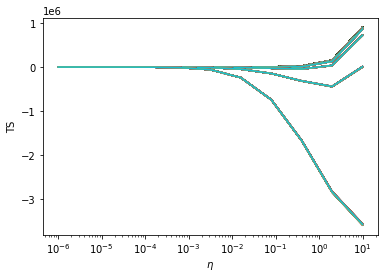

In [59]:

expect_sig = H.ud_grade(np.array(all_galactic_neutrinos_per_channel)[2][3][0], nside_course)*ud_grade_factor

TS_min_sig = TS_sig(expect_sig)
TS_min_bg = TS_bg(expect_sig)

TS_min_bg = np.array(TS_min_bg) 
TS_min_sig = np.array(TS_min_sig)        

TS_0 = TS_min_bg.mean()
f = np.zeros(len(eta_sim_sig))
for i in range(len(eta_sim_sig)):
    f[i] = len(TS_min_sig[i][np.where(TS_min_sig[i]>=TS_0)]) /len(TS_min_sig[i])



<ipython-input-60-90c2bee9d643>:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.axvline(TS_min_bg.mean(), color='k', linestyle='dashed', linewidth=1)


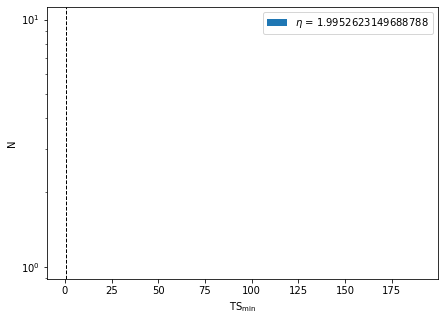

In [60]:
nbins=np.arange(0,200,10)
fig, ax = plt.subplots(figsize = (7,5))
ax.hist(TS_min_sig[9], log=True, bins=nbins, label='$\eta$ = '+str(eta_sim_sig[9]))
#ax.hist(TS_min_bg, log=True, bins=nbins, label='bg')
ax.axvline(TS_min_bg.mean(), color='k', linestyle='dashed', linewidth=1)
ax.set_xlabel(r"$\rm{TS}_{\rm{min}}$")
ax.set_ylabel("N")
plt.legend();

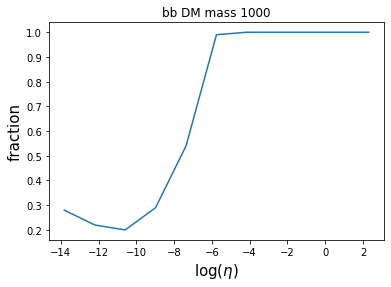

In [61]:
plt.plot(np.log(eta_sim_sig), f)
plt.ylabel('fraction', fontsize=15)
plt.xlabel('log($\eta$)', fontsize=15)
plt.title('bb DM mass 1000');

In [46]:
def func(eta, eta0, a):
    return (1-a)*special.erf(eta/eta0/np.sqrt(2))+a

#yerror = np.sqrt(f*(1-f)/samples_ts)
yerror = np.sqrt((2+(samples_ts_sig-6)*(1-f)*f)/(samples_ts_sig+2)/(samples_ts_sig+3))
bounds=((0.01, [40, 1.]))


popt1, pcov1 = curve_fit(func, eta_sim_sig, f, sigma=yerror, absolute_sigma=True)

eta_prime = bisect(lambda x: func(x, *popt1) -0.9, eta_sim_sig[0], eta_sim_sig[-1])

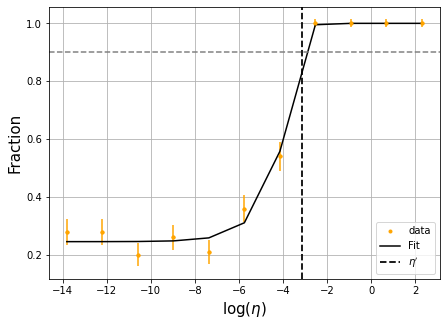

In [47]:
fig, ax = plt.subplots(figsize = (7,5))
ax.plot(np.log(eta_sim_sig), f, '.', label='data', color='orange')
ax.errorbar(np.log(eta_sim_sig), f, yerr=yerror, fmt = '.', color='orange')
ax.plot(np.log(eta_sim_sig), func(eta_sim_sig, *popt1), label= 'Fit', color='black')
#ax.plot(eta_sim_sig, special.erf(eta_sim_sig/np.sqrt(2)), '--', label='Erf func')
ax.set_xlabel("log($\mathit{\eta}$)", fontsize=15)
ax.set_ylabel('Fraction', fontsize=15) #("$\%$")
ax.axhline(.9, color='grey', linestyle='dashed', linewidth=1.5)
#ax.axvline(popt1[0], color='k', linestyle='dashed', linewidth=1.75, label=r"$\mathit{\eta_0}$")
ax.axvline(np.log(eta_prime), color='k', linestyle='dashed', linewidth=1.75, label=r"$\mathit{\eta'}$")
ax.grid(True)
ax.legend(loc='lower right');

# Upload previous maps

In [ ]:
expect_bg = H.ud_grade(all_atmospheric_neutrinos,nside_course)*ud_grade_factor
total_signal = all_galactic_neutrinos_per_channel+all_atmospheric_neutrinos


# Loop begins here
__1) TS for background.__

__2) TS for background + signal.__

__3) Fitting and finding $\eta'$ + saving.__

__4) Sensitivity plot.__

In [ ]:
saved_bg_histograms = []
saved_histograms = []

TS_0 = TS_min_bg.mean()

def func(eta, eta0, a):
    return (1-a)*special.erf(eta/eta0/np.sqrt(2))+a

saved_eta_prime = []

for c in tqdm(range(len(channels))):
    for m in range(len(DM_masses)):
        expect_sig = H.ud_grade(np.array(all_galactic_neutrinos_per_channel)[c][m][0], nside_course)*ud_grade_factor
        
        #Calculating TS for background
        TS_min_bg = TS_bg(expect_sig)
        saved_bg_histograms.append(TS_min_bg)
        TS_min_bg = np.array(TS_min_bg)
        
        #Calculating TS for signal
        TS_min_sig = TS_sig(expect_sig)
        saved_histograms.append(TS_min_sig)
        TS_min_sig = np.array(TS_min_sig)        
        
        #How many TS_min_sig is above 90% the mean of TS_min_bg
        f = np.zeros(len(eta_sim_sig))
        for i in range(len(eta_sim_sig)):
            f[i] = len(TS_min_sig[i][np.where(TS_min_sig[i]>=TS_0)]) /len(TS_min_sig[i])
        
        #Estimation of ydata error
        yerror = np.sqrt((2+(samples_ts-6)*(1-f)*f)/(samples_ts+2)/(samples_ts+3))
        #Fitting
        popt1, pcov1 = curve_fit(func, eta_sim_sig, f, sigma=yerror, absolute_sigma=True, maxfev=5000)
        #Finding eta_prime
        eta_prime = bisect(lambda x: func(x, *popt1) -0.9, eta_sim_sig[0], eta_sim_sig[-1])
        saved_eta_prime.append(eta_prime*1e-24)
         

In [ ]:
saved_bg_histograms = np.array(saved_bg_histograms)
saved_histograms = np.array(saved_histograms)
saved_eta_prime = np.array(saved_eta_prime)

In [ ]:
saved_eta_prime

## Saving histograms and sensitivities

In [ ]:
np.save('saved_bg_histograms_decay.npy',saved_bg_histograms)
np.save('saved_eta_prime_decay.npy',saved_eta_prime)
np.save('saved_histograms_decay.npy',saved_histograms)

## Plotting sensitivity

In [ ]:
fig, ax = plt.subplots(figsize = (7,5))
ax.plot(DM_masses, saved_eta_prime[:5], label=r'$b\bar{b}$', color='blue')
ax.plot(DM_masses[2:], saved_eta_prime[7:10], label=r'$W^{+}W^{-}$', color='purple')
ax.plot(DM_masses, saved_eta_prime[10:15], label=r'$\nu_{\mu}\bar{\nu}_{\mu}$', color='darkorange')
ax.plot(DM_masses, saved_eta_prime[15:20], label=r'$\tau^{+}\tau^{-}$', color='green')
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$\Gamma, [s^{-1}]$ ", fontsize=15) 
ax.set_xlabel(r"$m_{\chi} \, [GeV]$", fontsize=15)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.17), ncol=4,  fontsize=14)
ax.grid(True)
ax.set_ylim(1e-31,3e-29)
ax.set_xlim(7.5, 1.5e3)
plt.savefig('sensitivity_gamma.png', dpi=300);

In [ ]:
fig, ax = plt.subplots(figsize = (7,5))
ax.plot(DM_masses, saved_eta_prime[:5]*-1, label=r'$b\bar{b}$', color='blue')
ax.plot(DM_masses[2:], saved_eta_prime[7:10]*-1, label=r'$W^{+}W^{-}$', color='purple')
ax.plot(DM_masses, saved_eta_prime[10:15]*-1, label=r'$\nu_{\mu}\bar{\nu}_{\mu}$', color='darkorange')
ax.plot(DM_masses, saved_eta_prime[15:20]*-1, label=r'$\tau^{+}\tau^{-}$', color='green')
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$\tau, [s]$ ", fontsize=15) 
ax.set_xlabel(r"$m_{\chi} \, [GeV]$", fontsize=15)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.17), ncol=4,  fontsize=14)
ax.grid(True)
ax.set_ylim(1e-31,3e-29)
ax.set_xlim(7.5, 1.5e3)
plt.savefig('sensitivity_lifetime.png', dpi=300);